# Dense AutoEncoder

In [0]:
import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Sequential, Model


def load_flatten_mnist_dataset():
  # Load the MNIST dataset from Keras
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  # Rescale images
  x_train = x_train.astype('float32') / 255.
  x_test = x_test.astype('float32') / 255.
  # Reshape images
  x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
  x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
  # Return the preprocessed MNIST images
  return x_train, y_train, x_test, y_test

def create_dense_autoencoder(input_dimension=784, latent_dimension=32):
  # Create layers of the autoencoder structure
  input_data = Input(shape=(input_dimension,))
  encoded_data = Dense(latent_dimension, activation='relu')(input_data)
  decoded_data = Dense(input_dimension, activation='sigmoid')(encoded_data)
  encoded_input = Input(shape=(latent_dimension,))
  # Create the autoencoder/encoder/decoder models
  autoencoder = Model(input_data, decoded_data)
  encoder = Model(input_data, encoded_data)
  decoder = Model(encoded_input, autoencoder.layers[-1](encoded_input))
  # Compile the autoencoder model
  autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
  # Return the different autoencoder model parts
  return autoencoder, encoder, decoder


# Load the MNIST dataset (flattened to 784-long)
x_train, y_train, x_test, y_test = load_flatten_mnist_dataset()

# Create the autoencoder models
autoencoder, encoder, decoder = create_dense_autoencoder(input_dimension=784, latent_dimension=32)

# Fit the dense autoencoder on the MNIST training dataset
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True)

In [0]:
from keras.utils import to_categorical


def encode_images(encoder, images):
  # Pass forward the input images through the encoder part
  return encoder.predict(images)

def create_classifier(input_dimension=32, output_dimension=10):
  # Create the classifier model
  classifier = Sequential()
  classifier.add(Dense(16, input_dim=input_dimension, activation='relu'))
  classifier.add(Dense(output_dimension, activation='softmax'))
  # Compile the classifier model
  classifier.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  return classifier


# Encode the training images by passing them trough the encoder model
encoded_x_train = encode_images(encoder, x_train)

# Create the classifier model that will discriminate latent dimensions
classifier = create_classifier(input_dimension=32, output_dimension=10)

# Fit the classifier to make it predict the MNIST figures from latent vectors
classifier.fit(encoded_x_train, to_categorical(y_train), epochs=10, batch_size=32)

Epoch 1/10
60000/60000 [==============================] - 5s 89us/step - loss: 0.9774 - acc: 0.7154
Epoch 2/10
60000/60000 [==============================] - 5s 85us/step - loss: 0.4087 - acc: 0.8758
Epoch 3/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.3644 - acc: 0.8902
Epoch 4/10
60000/60000 [==============================] - 5s 82us/step - loss: 0.3434 - acc: 0.8981
Epoch 5/10
60000/60000 [==============================] - 5s 83us/step - loss: 0.3280 - acc: 0.9032
Epoch 6/10
60000/60000 [==============================] - 5s 85us/step - loss: 0.3163 - acc: 0.9058
Epoch 7/10
60000/60000 [==============================] - 5s 84us/step - loss: 0.3080 - acc: 0.9082
Epoch 8/10
60000/60000 [==============================] - 5s 84us/step - loss: 0.3004 - acc: 0.9098
Epoch 9/10
60000/60000 [==============================] - 5s 84us/step - loss: 0.2954 - acc: 0.9127
Epoch 10/10
60000/60000 [==============================] - 5s 84us/step - loss: 0.2908 - acc: 0.9146

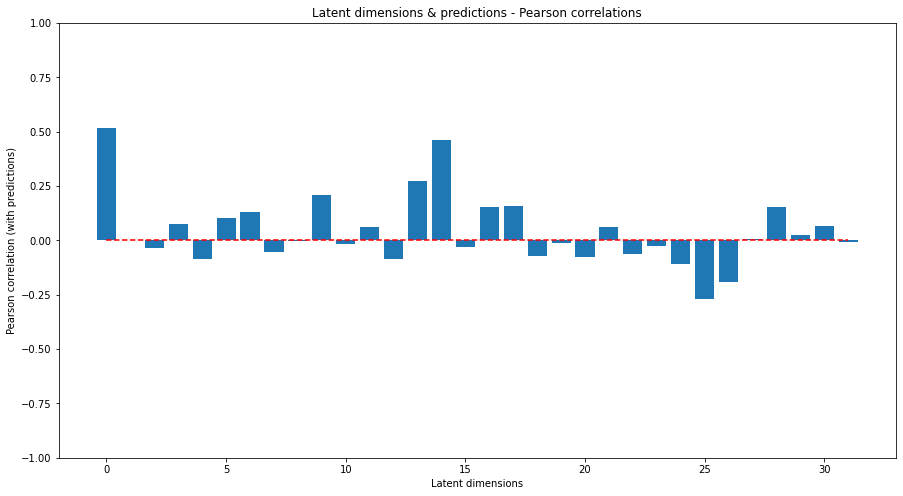

In [0]:
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt


def compute_pearson_correlations(encoded_images, predictions):
  # Compute Pearson linear correlation score between each latent dimension and the prediction
  correlations = [pearsonr(encoded_images[:, i], predictions)[0] for i in range(encoded_images.shape[1])]
  return correlations

def plot_latent_dimensions_predictions_correlations(correlations):
  # Initialize the x axis for the correlation plot
  latent_dimensions = [i for i in range(len(correlations))]
  # Plot the correlations between latent variables and predictions
  plt.figure(figsize=(15, 8))
  plt.bar(latent_dimensions, correlations)
  plt.plot([0, len(correlations)-1], [0., 0.], 'r--')
  plt.ylim([-1., 1.])
  plt.title('Latent dimensions & predictions - Pearson correlations')
  plt.xlabel('Latent dimensions')
  plt.ylabel('Pearson correlation (with predictions)')
  plt.show()


# Make predictions with the classifier on latent dimensions encoded from all data
prediction_encoded_images = np.argmax(classifier.predict(encoded_x_train), axis=1)

# Compute (Pearson) correlations between latent dimensions and predictions
correlations = compute_pearson_correlations(encoded_x_train, prediction_encoded_images)

# Plot the correlations between latent variables and predictions made on encoded images
plot_latent_dimensions_predictions_correlations(correlations)

# Convolutional AutoEncoder

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential, Model
from keras import backend as K


def load_mnist_dataset():
  # Load the MNIST dataset from Keras
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  # Rescale images
  x_train = x_train.astype('float32') / 255.
  x_test = x_test.astype('float32') / 255.
  # Reshape images
  x_train = x_train.reshape((len(x_train), 28, 28, 1))
  x_test = x_test.reshape((len(x_test), 28, 28, 1))
  # Return the preprocessed MNIST images
  return x_train, y_train, x_test, y_test


def create_convolutional_autoencoder(input_dimension=(28, 28, 1)):
  # Create layers of the encoder structure
  input_data = Input(shape=input_dimension)
  conv_layer_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_data)
  pool_layer_1 = MaxPooling2D((2, 2), padding='same')(conv_layer_1)
  conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool_layer_1)
  pool_layer_2 = MaxPooling2D((2, 2), padding='same')(conv_layer_2)
  conv_layer_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool_layer_2)
  encoded_data = MaxPooling2D((2, 2), padding='same')(conv_layer_3)
  # Create layers of the decoder structure
  deconv_layer_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_data)
  upsamp_layer_1 = UpSampling2D((2, 2))(deconv_layer_1)
  deconv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(upsamp_layer_1)
  upsamp_layer_2 = UpSampling2D((2, 2))(deconv_layer_2)
  deconv_layer_3 = Conv2D(16, (3, 3), activation='relu')(upsamp_layer_2)
  upsamp_layer_3 = UpSampling2D((2, 2))(deconv_layer_3)
  decoded_data = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(upsamp_layer_3)
  # Create the autoencoder models
  autoencoder = Model(input_data, decoded_data)
  encoder = Model(input_data, encoded_data)
  # Compile the autoencoder model
  autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
  # Return the different autoencoder model parts
  return autoencoder, encoder


# Load the MNIST dataset
x_train, y_train, x_test, y_test = load_mnist_dataset()

# Create the convolutional autoencoder model
autoencoder, encoder = create_convolutional_autoencoder(input_dimension=(28, 28, 1))

# Fit the convolutional autoencoder on the MNIST training dataset
autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, shuffle=True)

In [0]:
from keras.utils import to_categorical


def encode_images(encoder, images):
  # Pass forward the input images through the encoder part
  return encoder.predict(images).reshape(60000, -1)

def create_classifier(input_dimension=128, output_dimension=10):
  # Create the classifier model
  classifier = Sequential()
  classifier.add(Dense(64, input_dim=input_dimension, activation='relu'))
  classifier.add(Dense(16, activation='relu'))
  classifier.add(Dense(output_dimension, activation='softmax'))
  # Compile the classifier model
  classifier.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  return classifier


# Encode the training images by passing them trough the encoder model
encoded_x_train = encode_images(encoder, x_train)

# Create the classifier model that will discriminate latent dimensions
classifier = create_classifier(input_dimension=128, output_dimension=10)

# Fit the classifier to make it predict the MNIST figures from latent vectors
classifier.fit(encoded_x_train, to_categorical(y_train), epochs=10, batch_size=32)

Epoch 1/10
60000/60000 [==============================] - 6s 101us/step - loss: 0.4653 - acc: 0.8591
Epoch 2/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.2103 - acc: 0.9342
Epoch 3/10
60000/60000 [==============================] - 6s 95us/step - loss: 0.1776 - acc: 0.9452
Epoch 4/10
60000/60000 [==============================] - 6s 96us/step - loss: 0.1576 - acc: 0.9501
Epoch 5/10
60000/60000 [==============================] - 6s 95us/step - loss: 0.1442 - acc: 0.9548
Epoch 6/10
60000/60000 [==============================] - 6s 96us/step - loss: 0.1365 - acc: 0.9581
Epoch 7/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.1298 - acc: 0.9588
Epoch 8/10
60000/60000 [==============================] - 6s 96us/step - loss: 0.1232 - acc: 0.9616
Epoch 9/10
60000/60000 [==============================] - 6s 101us/step - loss: 0.1191 - acc: 0.9632
Epoch 10/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.1163 - acc: 0.9

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


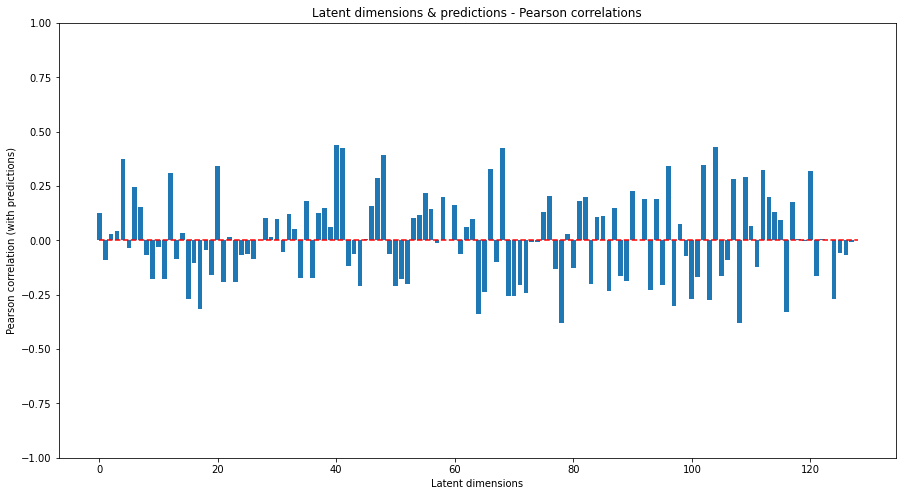

In [0]:
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt


def compute_pearson_correlations(encoded_images, predictions):
  # Compute Pearson linear correlation score between each latent dimension and the prediction
  correlations = [pearsonr(encoded_images[:, i], predictions)[0] for i in range(encoded_images.shape[1])]
  return correlations

def plot_latent_dimensions_predictions_correlations(correlations):
  # Initialize the x axis for the correlation plot
  latent_dimensions = [i for i in range(len(correlations))]
  # Plot the correlations between latent variables and predictions
  plt.figure(figsize=(15, 8))
  plt.bar(latent_dimensions, correlations)
  plt.plot([0, len(correlations)], [0., 0.], 'r--')
  plt.ylim([-1., 1.])
  plt.title('Latent dimensions & predictions - Pearson correlations')
  plt.xlabel('Latent dimensions')
  plt.ylabel('Pearson correlation (with predictions)')
  plt.show()


# Make predictions with the classifier on latent dimensions encoded from all data
prediction_encoded_images = np.argmax(classifier.predict(encoded_x_train), axis=1)

# Compute (Pearson) correlations between latent dimensions and predictions
correlations = compute_pearson_correlations(encoded_x_train, prediction_encoded_images)

# Plot the correlations between latent variables and predictions made on encoded images
plot_latent_dimensions_predictions_correlations(correlations)